In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

'''
y[n] = exp(-i 2*pi*n*k/N) + w[n]
w[n] = a[n] + ib[n]
SNR = (1/(s^2))
SNRdB = 10*log10(SNR). 
'''


'\ny[n] = exp(-i 2*pi*n*k/N) + w[n]\nw[n] = a[n] + ib[n]\nSNR = (1/(s^2))\nSNRdB = 10*log10(SNR). \n'

In [2]:
def pure_signal(N, k):
    return [np.exp(-1j * 2 * np.pi * k * n / N) for n in range(N)]

def noisy_signal(N, k, SNRdB):
    signal = pure_signal(N, k)
    s = np.sqrt(1 / (10 ** (SNRdB / 10)))
    a = np.random.randn(N) * s / np.sqrt(2)
    b = np.random.randn(N)* s / np.sqrt(2)
    noise = a + 1j*b
    return signal + noise

# returns tuple of m samples of noisy signals and chosen sampling indices
def subsampled_noisy(N, k, SNRdB, m):
    noisy_sig = noisy_signal(N, k, SNRdB)
    chosen_indices = np.sort(np.random.choice(range(N), size=m, replace=False))
    return (np.take(noisy_sig, chosen_indices), chosen_indices)

def imag_to_pair(signal):
    ret = []
    for i in signal:
        ret.append(np.round(np.real(i), 3))
        ret.append(np.round(np.imag(i), 3))
    return ret

def one_hot(N, batch_size, freqs):
    freqs_one_hot = np.zeros((batch_size, N))
    freqs_one_hot[np.arange(batch_size), freqs] = 1
    return freqs_one_hot

def batch_pure(N, batch_size):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = pure_signal(N, freq)
        signals.append(imag_to_pair(signal))
        freqs.append(freq)
    return signals, one_hot(N, batch_size, freqs)

def batch_noisy(N, SNRdB, batch_size):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = noisy_signal(N, freq, SNRdB)
        signals.append(imag_to_pair(signal))
        freqs.append(freq)
    return signals, one_hot(N, batch_size, freqs)
        
def batch_noisy_subsampled(N, SNRdB, m, batch_size):
    signals, freqs, indices = [], [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal, index = subsampled_noisy(N, freq, SNRdB, m)
        signals.append(imag_to_pair(signal))
        freqs.append(freq)
        indices.append(index)
    return signals, one_hot(N, batch_size, freqs), indices

def batch_noisy_subsampled(N, SNRdB, m, batch_size, indices):
    signals, freqs, repeated_ind = [], [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = noisy_signal(N, freq, SNRdB)
        sub_signal = np.take(signal, indices)
        signals.append(imag_to_pair(sub_signal))
        freqs.append(freq)
        repeated_ind.append(indices)
    return signals, one_hot(N, batch_size, freqs), repeated_ind

def test_noisy_mle(N, signals, freqs):
    count = 0
    imag_signals = []    
    for index in range(len(signals)):
        sig = signals[index]
        imag_sig = [(sig[i] + 1j*sig[i+1]) for i in np.arange(len(sig), step=2)]
        imag_signals.append(imag_sig)
                     
    for index in range(len(signals)):
        cleans = [pure_signal(N, i) for i in range(N)]
        dots = [np.absolute(np.vdot(imag_signals[index], cleans[i])) for i in range(N)]
        if np.argmax(freqs[index]) == np.argmax(dots):
            count += 1
    return count / len(freqs)

def test_noisy_subsampled_mle(N, signals, freqs, indices):
    count = 0
    imag_signals = []    
    for index in range(len(signals)):
        sig = signals[index]
        imag_sig = [(sig[i] + 1j*sig[i+1]) for i in np.arange(len(sig), step=2)]
        imag_signals.append(imag_sig)
                     
    for index in range(len(signals)):
        cleans = [np.take(pure_signal(N, i), indices[index]) for i in range(N)]
        dots = [np.absolute(np.vdot(imag_signals[index], cleans[i])) for i in range(N)]
        if np.argmax(freqs[index]) == np.argmax(dots):
            count += 1
    return count / len(freqs)



In [3]:
'''test_signals, test_freqs, test_ind = batch_noisy_subsampled(100, 0, 10, 100)
print(test_noisy_subsampled_mle(100, test_signals, test_freqs, test_ind))'''

'test_signals, test_freqs, test_ind = batch_noisy_subsampled(100, 0, 10, 100)\nprint(test_noisy_subsampled_mle(100, test_signals, test_freqs, test_ind))'

In [4]:
'''N = 10
m = 5

chosen_indices = np.random.choice(range(N), size=m, replace=False)
sig = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ind = [0, 5, 2, 7]
np.take(sig, np.sort(ind))
a = subsampled_noisy(8, 1, 10, 4)
np.real(a[1])
sig, freq = batch_noisy_subsampled(4, 3, 1, 2)
print(sig)
print(freq)
'''


'N = 10\nm = 5\n\nchosen_indices = np.random.choice(range(N), size=m, replace=False)\nsig = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]\nind = [0, 5, 2, 7]\nnp.take(sig, np.sort(ind))\na = subsampled_noisy(8, 1, 10, 4)\nnp.real(a[1])\nsig, freq = batch_noisy_subsampled(4, 3, 1, 2)\nprint(sig)\nprint(freq)\n'

In [5]:
'''snr = -10
N = 512
m = 50
num_trials = 1000
count = 0
for ind in range(num_trials):
    k = np.random.randint(0, N)
    noisy, indices = subsampled_noisy(N, k, snr, m)
    cleans = [np.take(pure_signal(N, i), indices) for i in range(N)]
    dots = [np.absolute(np.vdot(cleans[i], noisy)) for i in range(N)] 
    if k == np.argmax(dots):
        count += 1
print(count / num_trials)
'''

'snr = -10\nN = 512\nm = 50\nnum_trials = 1000\ncount = 0\nfor ind in range(num_trials):\n    k = np.random.randint(0, N)\n    noisy, indices = subsampled_noisy(N, k, snr, m)\n    cleans = [np.take(pure_signal(N, i), indices) for i in range(N)]\n    dots = [np.absolute(np.vdot(cleans[i], noisy)) for i in range(N)] \n    if k == np.argmax(dots):\n        count += 1\nprint(count / num_trials)\n'

In [40]:
N = 512
SNRdB = 0
m = 64

# Parameters
learning_rate = 0.01
num_iter = 1000
batch_size = 64

# Network Parameters
n_hidden_1 = 128#256 
n_hidden_2 = 64#256 
n_hidden_3 = 128#256
num_input = m * 2 #512 
num_classes = N

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_3, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

indices = np.sort(np.random.choice(range(N), size=m, replace=False))

test_signals, test_freqs, test_indices = batch_noisy_subsampled(N, SNRdB, m, batch_size, indices)

In [41]:
def neural_net(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])

    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']
    return out_layer

In [42]:
# Construct model
logits = neural_net(X)
prediction = tf.nn.softmax(logits)
losses, accuracies = [], []

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_iter + 1):
        batch_x, batch_y, batch_ind = batch_noisy_subsampled(N, SNRdB, m, batch_size, indices)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % 10 == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            accuracies.append(acc)
            losses.append(loss)
            print("Iter " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Training Finished")

    print("Testing Accuracy Neural:", \
        sess.run(accuracy, feed_dict={X: test_signals,
                                      Y: test_freqs}))
    
    print("Testing Accuracy MLE:", test_noisy_subsampled_mle(N, test_signals, test_freqs, test_indices)) 

Iter 10, Minibatch Loss= 29639.0742, Training Accuracy= 0.000
Iter 20, Minibatch Loss= 21083.1855, Training Accuracy= 0.031
Iter 30, Minibatch Loss= 17386.5898, Training Accuracy= 0.031
Iter 40, Minibatch Loss= 14249.5898, Training Accuracy= 0.047
Iter 50, Minibatch Loss= 11171.3330, Training Accuracy= 0.094
Iter 60, Minibatch Loss= 7847.0166, Training Accuracy= 0.141
Iter 70, Minibatch Loss= 7733.9141, Training Accuracy= 0.203
Iter 80, Minibatch Loss= 6141.0928, Training Accuracy= 0.234
Iter 90, Minibatch Loss= 5779.8979, Training Accuracy= 0.203
Iter 100, Minibatch Loss= 2815.5181, Training Accuracy= 0.328
Iter 110, Minibatch Loss= 3917.0513, Training Accuracy= 0.250
Iter 120, Minibatch Loss= 3258.0276, Training Accuracy= 0.344
Iter 130, Minibatch Loss= 2549.5947, Training Accuracy= 0.406
Iter 140, Minibatch Loss= 2085.4180, Training Accuracy= 0.500
Iter 150, Minibatch Loss= 2348.5562, Training Accuracy= 0.359
Iter 160, Minibatch Loss= 1242.4329, Training Accuracy= 0.516
Iter 170, Mi

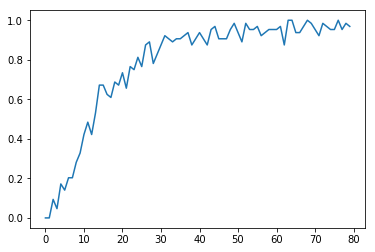

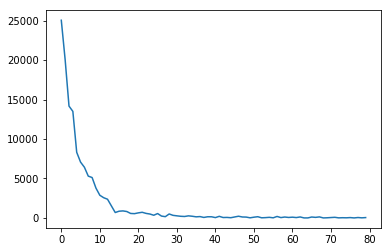

'\n500 iter, N=256,3 hidden layer each w 256 neuron, batchsize=32\nfully sampled: test accuracy ~98%\nm=240: test accuracy ~28%'

In [36]:
plt.plot(accuracies)
plt.show()
plt.plot(losses)
plt.show()

'''
500 iter, N=256,3 hidden layer each w 256 neuron, batchsize=32
fully sampled: test accuracy ~98%
m=240: test accuracy ~28%'''
